In [5]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates #for working with dates in plots

In [6]:
PATH = "../data/dfmerged_dailysynenv.csv"
df = pd.read_csv(PATH)
df.head()

df["synconc"] = np.log(df["synconc"])
df.rename(columns = {'date':'ds','synconc':'y','Beam_temperature_corrected':'temp','AvgSolar':'light'}, inplace = True)
# print(df[["ds","y","temp"]].dropna().head())
df.head()

,ds,light,AvgWindDir,AvgWindSpeed,temp,NH4_mean,NO3_mean,PO4_mean,SiO2_mean,doy,doy_numeric,month,monthname,y,year
0,2003-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-05-10,130,5.0,May,5.869825,2003
1,2003-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-05-11,131,5.0,May,5.945203,2003
2,2003-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-05-12,132,5.0,May,6.229464,2003
3,2003-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-05-13,133,5.0,May,6.557437,2003
4,2003-05-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-05-14,134,5.0,May,6.800940,2003


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
light,3074.0,149.891778,94.450048,-2.800000,74.079861,132.141071,228.845833,851.388235
AvgWindDir,3074.0,198.149130,72.314866,13.912500,150.370833,210.491024,252.054167,340.055556
AvgWindSpeed,3074.0,5.216600,2.309749,0.729167,3.635764,4.793056,6.316319,25.530556
temp,3074.0,10.641422,6.403568,-1.419508,4.714215,10.633121,16.645245,21.855795
NH4_mean,3.0,0.579822,0.213064,0.336760,0.502571,0.668381,0.701353,0.734325
NO3_mean,3.0,0.316256,0.463775,0.041841,0.048523,0.055206,0.453464,0.851722
PO4_mean,3.0,0.272177,0.356990,0.052669,0.066217,0.079765,0.381931,0.684097
SiO2_mean,3.0,1.316951,0.228844,1.138648,1.187928,1.237208,1.406103,1.574998
doy_numeric,4743.0,187.127556,101.736581,1.000000,105.500000,187.000000,274.000000,366.000000
y,4009.0,9.368452,2.066911,3.914724,7.667577,9.935380,11.081019,12.686868


Empty DataFrame
Columns: [ds, y, temp]
Index: []


In [8]:
#  m = Prophet(mcmc_samples = 300)
m = Prophet(weekly_seasonality=False,daily_seasonality = False,changepoint_prior_scale=0.001)
# m.add_seasonality(name='season', period=90, fourier_order=5)
m.add_regressor('temp')
m.add_regressor('light')
m.fit(df[["ds","y","temp","light"]].dropna())

df_cv = cross_validation(m, initial='3000 days', period='365 days', horizon = '2095 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2012-12-09 00:00:00 and 2012-12-09 00:00:00


Initial log joint probability = -61.1004
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5489.83   0.000943327       5261.83      0.7957      0.7957      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       5492.91   4.49155e-07       4824.42   9.154e-11       0.001      218  LS failed, Hessian reset 
     165       5492.91   3.29994e-09       4760.51      0.2712      0.2712      237   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -22.3059
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3176.4   1.86785e-07       4990.55      0.4958      0.4958      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115        3176.4   9.26539e-09       5024.66      0.2538      0.2538      138   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


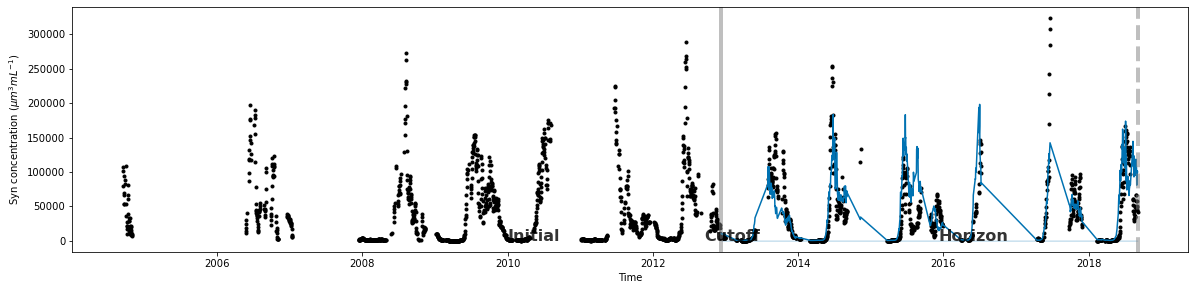

In [9]:
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

fig = plt.figure(facecolor='w', figsize=(20, 4.5))
ax = fig.add_subplot(111)

#PLOTTING OBSERVED DATA POINTS
ax.plot(m.history['ds'].values, np.exp(m.history['y']), 'k.')

# ax.set_ylim(0,400000)

#PLOTTING SIMULATION
ax.plot(df_cv['ds'].values, np.exp(df_cv['yhat']), ls='-', c='#0072B2')


ax.set_xlabel('Time')
ax.set_ylabel('Syn concentration ($\mu m^{3} mL^{-1}$)')


#PLOTTING UNCERTAINTY
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)

#LINE MARKING CUTOFF
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)

#LINE MARKING HORIZON
ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('2095 days'), c='gray', lw=4,
           alpha=0.5, ls='--')

#TEXT SAYING INITIAL
ax.text(x=pd.to_datetime('2010-01-01'),y=13, s='Initial', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

#TEXT SAYING CUTOFF
ax.text(x=pd.to_datetime('2012-08-01')+pd.Timedelta('45 days'),y=13
        , s='Cutoff', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

#TEXT SAYING HORIZON
ax.text(x=pd.to_datetime(cutoff) + pd.Timedelta('1095 days'),y=13, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8);

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# import matplotlib.dates as mdates #for working with dates in plots
# import seaborn as sns
# from calendar import month_name as mn
# import datetime
# from matplotlib.dates import MonthLocator, DateFormatter
# import numpy as np

In [12]:
df.head()

df.ds = pd.to_datetime(df.ds, format = "%Y-%m-%d")
df.doy = df.ds.dt.dayofyear

df_cv.ds = pd.to_datetime(df_cv.ds, format = "%Y-%m-%d")
df_cv.doy = df_cv.ds.dt.dayofyear

In [26]:
plt.figure(figsize=(15, 8), dpi=800)

# # for Palatino and other serif fonts use:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman"]})

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'font.size': 22})


plt.scatter(df.doy,np.exp(df.y), s= 5,c = "b")
plt.scatter(df_cv.doy,np.exp(df_cv.yhat),s = 5,c= "r")
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}')) #adds commas to yaxis tick marks
plt.xlabel("Day of the Year")
# plt.gca().xaxis.set_major_locator(MonthLocator())  # Tick locator
# plt.gca().xaxis.set_major_formatter(DateFormatter('%b')) 
plt.ylabel("$\it{Syn}$ Concentration ($cells$ $mL^{-1}$)")
plt.title("$\it{Synechecoccus}$ Concentration at MVCO")
plt.grid()
plt.legend(["Observed","Simulated"])

In [29]:
df_cv.head()

d = {"dt" : pd.to_datetime(df_cv["ds"]),
     'year':pd.to_numeric(df_cv["ds"].dt.year),
     'month':pd.to_numeric(df_cv["ds"].dt.month),
    "simulated_forecast":df_cv["yhat"],
    "observation":df_cv["y"]}

dfp = pd.DataFrame(data = d)

dfcv_long= pd.melt(dfp,id_vars =  ["dt","year","month"],value_name = "conc",var_name = "source")
dfcv_long.head()

,dt,year,month,source,conc
0,2012-12-10,2012,12,simulated_forecast,9.234929
1,2012-12-11,2012,12,simulated_forecast,9.303489
2,2012-12-12,2012,12,simulated_forecast,9.272688
3,2012-12-13,2012,12,simulated_forecast,9.192044
4,2012-12-14,2012,12,simulated_forecast,9.153561


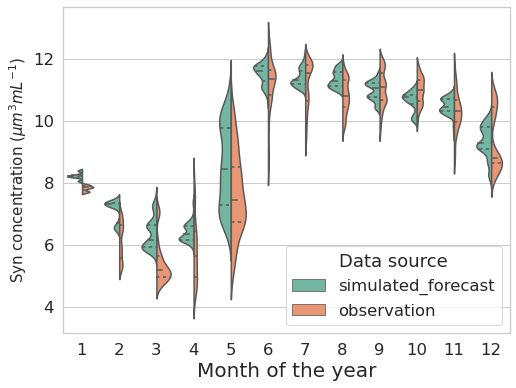

In [33]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(8,6)})
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
ax = sns.violinplot(x="month", y="conc",hue = "source", data=dfcv_long,palette = "Set2",split=True,inner="quartile", bw=.3)
ax.set_xlabel("Month of the year", fontsize = 20)
ax.set_ylabel("Syn concentration ($\mu m ^3 mL ^{-1}$)", fontsize = 15)
plt.legend(title = "Data source",loc = "lower right")